In [1]:
# SETUP
# =====
#%run ./data_Preprocessing.py
from geospatial import *
import nbimporter
import pickle
import numpy as np
import math
from itertools import chain
from data_Preprocessing import MotorwaySegment, MotorwayLine, write_to_pickle, read_from_pickle
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle



In [2]:
# Aim to add cell_index column
# =====
class CellSegment(MotorwaySegment):
    def __init__(self, motorwaysegment, precision=2):
        # Copy attributes from motorwaysegment
        self.__dict__ = motorwaysegment.__dict__.copy()
        # Add additional attributes
        self.index1 = 0
        self.index2 = 0
        self.precision = precision
        self.set_precision(precision)
    
    def set_precision(self,n_significant_digit=None):
        self.start.x = round(self.start.x, n_significant_digit)
        self.start.y = round(self.start.y, n_significant_digit)
        self.end.x = round(self.end.x, n_significant_digit)
        self.end.y = round(self.end.y, n_significant_digit)
        self.precision = n_significant_digit
        return
    
    def __repr__(self):
        return f'CellSegment of "{self.name}" with start {self.start} and end {self.end}, start cell in {self.index1} and end cell in {self.index2}.'
    

In [3]:
# Aim to package all the related variables and functions to one class
# =====
class CellLength():
    def __init__(self, data, box, res, precision=2):
        self.data = data
        # Number of grid rows and colums
        self.res = res #res = resolution
        self.precision = precision
        self.w = box.ur.x - box.ll.x
        self.h = box.ur.y - box.ll.y
        self.nCols = int(self.w/ self.res)+1
        self.nRows = int(self.h/ self.res)+1
        
        ur = Point(box.ll.x + (self.nCols * self.res), box.ll.y + (self.nRows * self.res))
        ll = box.ll
        self.bBox = Bbox([ll, ur])
        
        # Cell with index to store the length
        self.maxIndex = (self.nCols * self.nRows) -1        
        # Use a NumPy array instead of a list to store cellLength data (float16 to constrain memory use)
        self.cellLength = np.zeros(self.maxIndex + 1, dtype=np.float16)
            
    def addIndex(self):
        for segment in self.data:
            segment.index1 = self.pointIndex(segment.start)  # add index of start point
            segment.index2 = self.pointIndex(segment.end)  # add index of end point   
    
    def pointIndex(self, p): # Define the which cell the point is in
        j = int((p.y - self.bBox.ll.y)/ self.res)
        i = int((p.x - self.bBox.ll.x)/ self.res)
        return (j * self.nCols) + i    
    
    def addLength(self):
        self.addIndex()

        self.length = 0
        self.seg_ab = []

        for seg in self.data:
            seg_length = self.segLength(seg.start, seg.end)
            if seg.index1 == seg.index2: # if in the same cell
                index = seg.index1
                self.cellLength[index] += seg_length
                self.length += seg_length
            else:
                point1 = seg.start
                point2 = seg.end
                index1 = seg.index1
                index2 = seg.index2

                j1 = int((point1.y - self.bBox.ll.y) / self.res)
                i1 = int((point1.x - self.bBox.ll.x) / self.res)
                j2 = int((point2.y - self.bBox.ll.y) / self.res)
                i2 = int((point2.x - self.bBox.ll.x) / self.res)

                min_i = min(i1,i2)
                max_i = max(i1,i2)
                min_j = min(j1,j2)
                max_j = max(j1,j2)

                points = [point1, point2]

                if point1.x == point2.x:
                    # Handle vertical line segment
                    while min_j < max_j: 
                        intersect_y = (min_j + 1)*self.res + self.bBox.ll.y 
                        intersect_x = point1.x
                        point_new = Point(intersect_x,intersect_y)
                        points.append(point_new)
                        min_j += 1
                elif point1.y == point2.y:
                    # Handle horizontal line segment
                    while min_i < max_i: 
                        intersect_x = (min_i + 1)*self.res + self.bBox.ll.x 
                        intersect_y = point1.y
                        point_new = Point(intersect_x,intersect_y)
                        points.append(point_new)
                        min_i += 1
                else:
                    k = (point2.y - point1.y)/(point2.x - point1.x)
                    b =  point1.y - (k * point1.x)

                    while min_j < max_j: 
                        intersect_y = (min_j + 1)*self.res + self.bBox.ll.y 
                        intersect_x = (intersect_y - b)/k
                        point_new = Point(intersect_x,intersect_y)
                        points.append(point_new)
                        min_j += 1

                    while min_i < max_i: 
                        intersect_x = (min_i + 1)*self.res + self.bBox.ll.x
                        intersect_y = k*intersect_x + b
                        point_new = Point(intersect_x,intersect_y)
                        points.append(point_new)
                        min_i += 1

                # Sort points by x-coordinate
                points.sort(key=lambda p: p.x)

                # Calculate length
                for i in range(len(points)-1):
                    start = points[i]
                    end = points[i+1]
                    seg_cellindex = self.pointIndex(points[i+1])
                    length = self.segLength(start, end)
                    self.cellLength[seg_cellindex] += round(length, self.precision)

    def segLength(self,p1,p2):  # calculate segment length
        return p1.distEuclidean(p2) 
    

In [4]:
# The rest is in "main()"

# bBox and res (bBox is fixed, user can change res value)
xs = 2250000
xf = 3000000
ys = 1075000
yf = 1300000
box = Bbox([Point(xs, ys), Point(xf, yf)])
res = 100 # can change
precision = 2 #2: [cm], 3: [mm]

In [5]:
motorway_osm_lines = read_from_pickle("motorway_osm_lines.pkl")
motorway_osm_segments = list(chain(*map(lambda x: x.segments, motorway_osm_lines)))

In [ ]:
#%%timeit -n 1
# osm dataset: 
cellSegments_osm = [CellSegment(segment,precision) for segment in motorway_osm_segments]
cellLength_osm = CellLength(cellSegments_osm, box, res)
cellLength_osm.addIndex()
cellLength_osm.addLength()
cellLength_osm.cellLength

array([0., 0., 0., ..., 0., 0., 0.], dtype=float16)

In [ ]:
motorway_ch_lines = read_from_pickle("motorway_ch_lines.pkl")
motorway_ch_segments = list(chain(*map(lambda x: x.segments, motorway_ch_lines)))

In [ ]:
# Astra dataset:
cellSegments_astra = [CellSegment(segment,precision) for segment in motorway_ch_segments]
    
cellLength_astra = CellLength(cellSegments_astra, box, res)
cellLength_astra.addIndex()
cellLength_astra.addLength()
# Astra result
cellLength_astra.cellLength

array([0., 0., 0., ..., 0., 0., 0.], dtype=float16)

In [ ]:
# Comparison V3 (to increase resolution)
# Convert result1 and result2 to NumPy arrays
result1 = np.array(cellLength_osm.cellLength).round(precision)
result2 = np.array(cellLength_astra.cellLength).round(precision)

# Create a mask to select only the non-zero elements of result1 and result2
mask = (result1 != 0) & (result2 != 0)

# Exclude elements of result2 that are equal to zero
mask &= (result2 != 0)

# Compute result array using vectorized operations
result = np.full_like(result1, -1, dtype=np.float32)
np.divide(result1, result2, out=result, where=mask)
result *= 100
np.clip(result, -1, 100, out=result)

# Create a 2D array with shape (cellLength.nCols, cellLength.nRows)
a = result.reshape(cellLength_osm.nRows, cellLength_osm.nCols).T

print(a)

[[-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 ...
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]
 [-1. -1. -1. ... -1. -1. -1.]]


Mean: 86.12786102294922
Median: 100.0


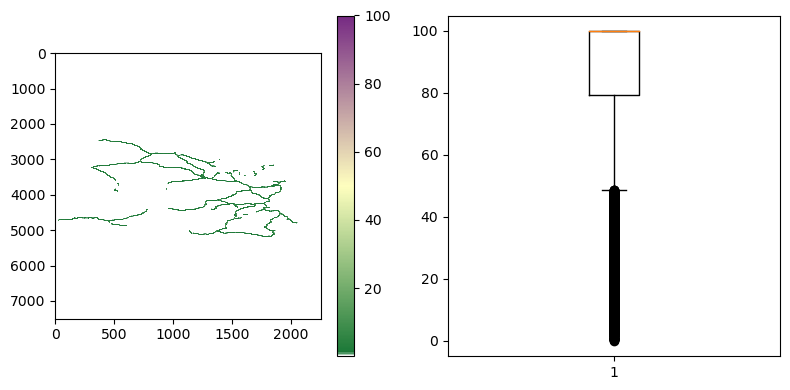

In [11]:
from matplotlib.colors import LinearSegmentedColormap

# Create a custom colormap
colors = [(0, 'white'), (0.01, '#1b7837'), (0.5, "#ffffbf"), (1, '#762a83')]
cmap = LinearSegmentedColormap.from_list('custom', colors)

fig, axs = plt.subplots(1, 2, figsize=(8, 4))
non_zero_a = a[a>0]


# Display the array as an image
ratio = a.shape[1]/a.shape[0]
im = axs[0].imshow(a, aspect=ratio, cmap=cmap, vmin=0.01, vmax=100)
fig.colorbar(im, ax=axs[0])

# Statistics
axs[1].boxplot(non_zero_a)
print(f"Mean: {np.mean(non_zero_a)}")
print(f"Median: {np.median(non_zero_a)}")

plt.tight_layout()
plt.show()

In [171]:
import rasterio
from rasterio.transform import from_origin

# Set geotransform
xs = 2250000
xf = 3000000
ys = 1075000
yf = 1300000
# This is an example, you need to set the values according to your data
transform = from_origin(xs/res, ys/res, xf/res, yf/res)

# Set CRS
# This is an example, you need to set the CRS according to your data
crs = {'init': 'epsg:2056'}

# Write array to file
with rasterio.open('result_completeness.tif', 'w', driver='GTiff', height=a.shape[1],
                   width=a.shape[0], count=1, dtype=a.dtype,
                   crs=crs, transform=transform) as dst:
    dst.write(a, 1)

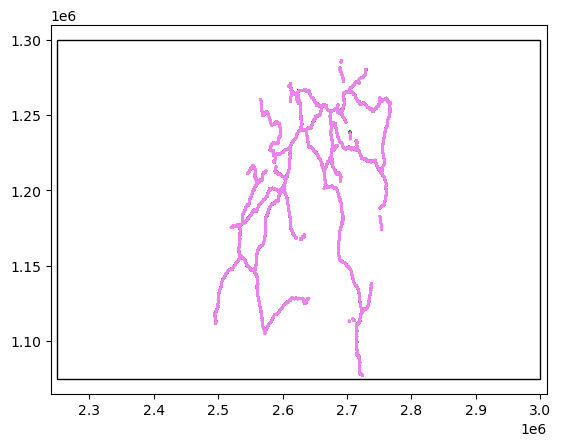

In [14]:
# This part is not needful, just to show where bBox is and osm data
figure, axes = plt.subplots()
rect = plt.Rectangle((cellLength_osm.bBox.ll.x,cellLength_osm.bBox.ll.y), cellLength_osm.w, cellLength_osm.h, fill= False)

for seg in cellSegments_osm:
    x1 = [seg.start.x, seg.end.x]
    y1 = [seg.start.y, seg.end.y]
    plt.plot(x1, y1, color="green")

for seg in cellSegments_astra:
    x1 = [seg.start.x, seg.end.x]
    y1 = [seg.start.y, seg.end.y]
    plt.plot(x1, y1, color="violet")
    
plt.xlim([xs-10000, xf+10000])
plt.ylim([ys-10000, yf+10000])
axes.add_artist(rect)
plt.show()